# Compare Image Classifier With and Without Differential Privacy Using TensorFlow and Keras


## Overview

[Differential privacy](https://en.wikipedia.org/wiki/Differential_privacy) (DP) is a framework for measuring the privacy guarantees provided by an algorithm. Through the lens of differential privacy, we can design machine learning algorithms that responsibly train models on private data. Learning with differential privacy provides provable guarantees of privacy, mitigating the risk of exposing sensitive training data in machine learning. Intuitively, a model trained with differential privacy should not be affected by any single training example, or small set of training examples, in its data set. This mitigates the risk of exposing sensitive training data in ML.

The basic idea of this approach, called differentially private stochastic gradient descent (DP-SGD), is to modify the gradients
used in stochastic gradient descent (SGD), which lies at the core of almost all deep learning algorithms. Models trained with DP-SGD provide provable differential privacy guarantees for their input data. There are two modifications made to the vanilla SGD algorithm:

1. First, the sensitivity of each gradient needs to be bounded. In other words, we need to limit how much each individual training point sampled in a minibatch can influence gradient computations and the resulting updates applied to model parameters. This can be done by *clipping* each gradient computed on each training point.
2. *Random noise* is sampled and added to the clipped gradients to make it statistically impossible to know whether or not a particular data point was included in the training dataset by comparing the updates SGD applies when it operates with or without this particular data point in the training dataset.

This tutorial uses [tf.keras](https://www.tensorflow.org/guide/keras) to train a convolutional neural network (CNN) to recognize handwritten digits with the DP-SGD optimizer provided by the TensorFlow Privacy library. TensorFlow Privacy provides code that wraps an existing TensorFlow optimizer to create a variant that implements DP-SGD.

## Setup

First, set this notebook's runtime to use a GPU, under Runtime > Change runtime type > Hardware accelerator. Then, begin importing the necessary libraries.

In [2]:
!pip install -q tensorflow==1.15.2

ERROR: tensorflow-privacy 0.5.1 has requirement tensorflow-estimator>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

# Install TensorFlow Privacy

In [4]:
!pip install -q tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

ERROR: tensorflow 1.15.2 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Load and Pre-Process the Dataset

Load the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and prepare the data for training.

In [5]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.

assert test_data.min() == 0.
assert test_data.max() == 1.

# Define and Tune Learning Model Hyper-Parameters
Set learning model hyperparamter values. 


In [6]:
epochs = 15
batch_size = 250

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 
4. `learning_rate` (float) - This hyperparameter already exists in vanilla SGD. The higher the learning rate, the more each update matters. If the updates are noisy (such as when the additive noise is large compared to the clipping threshold), a low learning rate may help the training procedure converge. 

Use the hyperparameter values below to obtain a reasonably accurate model (95% test accuracy):

In [7]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.000025

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Build the Model

Define a convolutional neural network as the learning model. 

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Train Without Privacy

Define the optimizer and loss function for the learning model. Compute the loss as a vector of losses per-example rather than as the mean over a minibatch to support gradient manipulation over each training point. 

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, 
    #reduction=tf.losses.Reduction.NONE
)

In [11]:
%%time

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=epochs,
                    validation_data=(test_data, test_labels),
                    batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 75us/sample - loss: 2.2900 - acc: 0.1448 - val_loss: 2.2661 - val_acc: 0.2325
Epoch 2/15
60000/60000 [==============================] - 5s 81us/sample - loss: 2.1768 - acc: 0.4067 - val_loss: 2.0474 - val_acc: 0.5726
Epoch 3/15
60000/60000 [==============================] - 4s 68us/sample - loss: 1.9440 - acc: 0.6552 - val_loss: 1.8590 - val_acc: 0.7016
Epoch 4/15
60000/60000 [==============================] - 4s 69us/sample - loss: 1.8245 - acc: 0.7132 - val_loss: 1.7918 - val_acc: 0.7212
Epoch 5/15
60000/60000 [==============================] - 4s 69us/sample - loss: 1.7781 - acc: 0.7305 - val_loss: 1.7607 - val_acc: 0.7345
Epoch 6/15
60000/60000 [==============================] - 4s 69us/sample - loss: 1.7539 - acc: 0.7406 - val_loss: 1.7430 - val_acc: 0.7428
Epoch 7/15
60000/60000 [==============================] - 4s 65us/sample - loss: 1.7392 - acc: 0.7466 - val_loss: 1.

# Analyze the Accuracy Without Privacy

In [12]:
# print(history.history)

In [13]:
print(history.history['val_acc'])

[0.2325, 0.5726, 0.7016, 0.7212, 0.7345, 0.7428, 0.7485, 0.753, 0.7562, 0.7584, 0.7605, 0.7636, 0.7645, 0.7663, 0.7678]


In [14]:
!pip install -q matplotlib==3.3.3

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


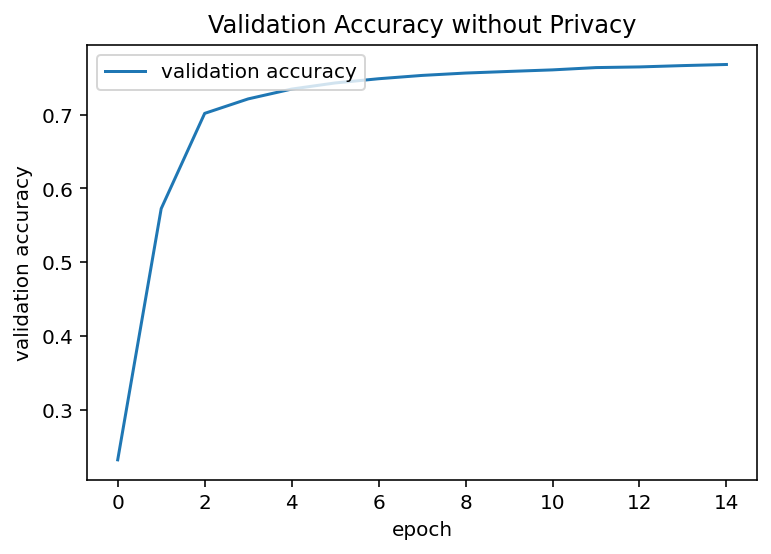

In [15]:
import matplotlib.pyplot as  plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Plot history: MAE
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Validation Accuracy without Privacy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Train with Privacy

Define the optimizer and loss function for the learning model. Compute the loss as a vector of losses per-example rather than as the mean over a minibatch to support gradient manipulation over each training point. 

In [16]:
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

## Compile and train the learning model with Privacy
TODO:  Keep an eye on 2 things here relative to the 1st (non-private) training job above:
1. The val_acc (validation accuracy).  Should explain why this accuracy is higher/lower than the accuracy of the non-privacy model above.  The narrative is that diff privacy creates a "blurring" effect on the training data, so this should be part of the explanation.
2. The time it takes to train.  My initial runs are showing 15x training time!!  The explanation will likely be something along the lines of "Differential privacy adds extra compute such as <fill-this-in>"




In [ ]:
%%time

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=epochs,
                    validation_data=(test_data, test_labels),
                    batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 1242s 21ms/sample - loss: 1.6972 - acc: 0.7692 - val_loss: 1.6968 - val_acc: 0.7678
Epoch 2/15
60000/60000 [==============================] - 1260s 21ms/sample - loss: 1.6971 - acc: 0.7692 - val_loss: 1.6968 - val_acc: 0.7678
Epoch 3/15
 3250/60000 [>.............................] - ETA: 19:57 - loss: 1.6875 - acc: 0.7791

# Analyze the Accuracy With Privacy

In [ ]:
# print(history.history)

In [ ]:
print(history.history['val_acc'])

In [ ]:
!pip install -q matplotlib==3.3.3

In [ ]:
import matplotlib.pyplot as  plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Plot history: MAE
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Validation Accuracy with Privacy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# TODO:  Explain how to use the following nice-to-have utility that helps you calculate choose a privacy budget.

## Measure the differential privacy guarantee

Perform a privacy analysis to measure the DP guarantee achieved by a training algorithm. Knowing the level of DP achieved enables the objective comparison of two training runs to determine which of the two is more privacy-preserving. At a high level, the privacy analysis measures how much a potential adversary can improve their guess about properties of any individual training point by observing the outcome of our training procedure (e.g., model updates and parameters). 

This guarantee is sometimes referred to as the **privacy budget**. A lower privacy budget bounds more tightly an adversary's ability to improve their guess. This ensures a stronger privacy guarantee. Intuitively, this is because it is harder for a single training point to affect the outcome of learning: for instance, the information contained in the training point cannot be memorized by the ML algorithm and the privacy of the individual who contributed this training point to the dataset is preserved.

In this tutorial, the privacy analysis is performed in the framework of Rényi Differential Privacy (RDP), which is a relaxation of pure DP based on [this paper](https://arxiv.org/abs/1702.07476) that is particularly well suited for DP-SGD.


Two metrics are used to express the DP guarantee of an ML algorithm:

1.   Delta ($\delta$) - Bounds the probability of the privacy guarantee not holding. A rule of thumb is to set it to be less than the inverse of the size of the training dataset. In this tutorial, it is set to **10^-5** as the MNIST dataset has 60,000 training points.
2.   Epsilon ($\epsilon$) - This is the privacy budget. It measures the strength of the privacy guarantee by bounding how much the probability of a particular model output can vary by including (or excluding) a single training point. A smaller value for $\epsilon$ implies a better privacy guarantee. However, the $\epsilon$ value is only an upper bound and a large value could still mean good privacy in practice.

Tensorflow Privacy provides a tool, `compute_dp_sgd_privacy.py`, to compute the value of $\epsilon$ given a fixed value of $\delta$ and the following hyperparameters from the training process:

1.   The total number of points in the training data, `n`.
2. The `batch_size`.
3.   The `noise_multiplier`.
4. The number of `epochs` of training.


In [ ]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=60000, batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

The tool reports that for the hyperparameters chosen above, the trained model has an $\epsilon$ value of 1.18.

## Summary
In this tutorial, you learned about differential privacy (DP) and how you can implement DP principles in existing ML algorithms to provide privacy guarantees for training data. In particular, you learned how to:
*   Wrap existing optimizers (e.g., SGD, Adam) into their differentially private counterparts using TensorFlow Privacy
*   Tune hyperparameters introduced by differentially private machine learning
*   Measure the privacy guarantee provided using analysis tools included in TensorFlow Privacy